# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [9]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [10]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter= ';')

In [11]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#number of rows and columns 
print('Number of Rows =',azdias.shape[0])
print('Number of Columns =',azdias.shape[1])



Number of Rows = 891221
Number of Columns = 85


In [12]:
#First few samples
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
print('Number of Rows=',feat_info.shape[0])
print('Number of Columns=',feat_info.shape[1])

Number of Rows= 85
Number of Columns= 4


In [14]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [15]:
feat_info.set_index('attribute',inplace= True)

In [16]:
# Identify missing or unknown data values and convert them to NaNs.

column_name=azdias.columns
column_name

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [17]:
azdias.isnull().any()

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

In [18]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [19]:
sum(azdias.isnull().sum())

4896838

In [20]:
import os
sizeinfo=os.stat('Udacity_AZDIAS_Subset.csv')
sizeinfo.st_size

157145280

In [21]:
def Nans(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [22]:
azdias_nan = Nans(azdias)

In [23]:
azdias_nan['AGER_TYP']

0         NaN
1         NaN
2         NaN
3         2.0
4         NaN
5         3.0
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        1.0
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        2.0
         ... 
891191    1.0
891192    NaN
891193    2.0
891194    NaN
891195    2.0
891196    NaN
891197    NaN
891198    NaN
891199    NaN
891200    NaN
891201    NaN
891202    NaN
891203    NaN
891204    NaN
891205    1.0
891206    NaN
891207    1.0
891208    NaN
891209    NaN
891210    NaN
891211    NaN
891212    NaN
891213    NaN
891214    NaN
891215    NaN
891216    NaN
891217    NaN
891218    NaN
891219    NaN
891220    NaN
Name: AGER_TYP, Length: 891221, dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [24]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
sum(azdias_nan.isnull().sum())
missing_data=azdias_nan.isnull().sum()
plot_missing_data= missing_data[missing_data > 0]/(azdias.shape[0]) * 100


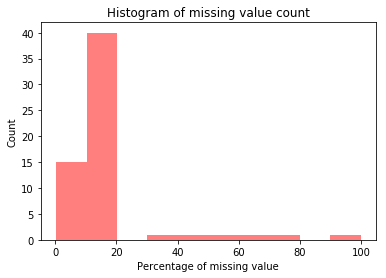

In [25]:
#Showing Distribution of Missing Data in Whole Data 
plt.hist(plot_missing_data, color='Red',alpha=0.50)

plt.xlabel('Percentage of missing value')
plt.ylabel('Count')
plt.title('Histogram of missing value count')
plt.show()

Text(0,0.5,'percent of missing values')

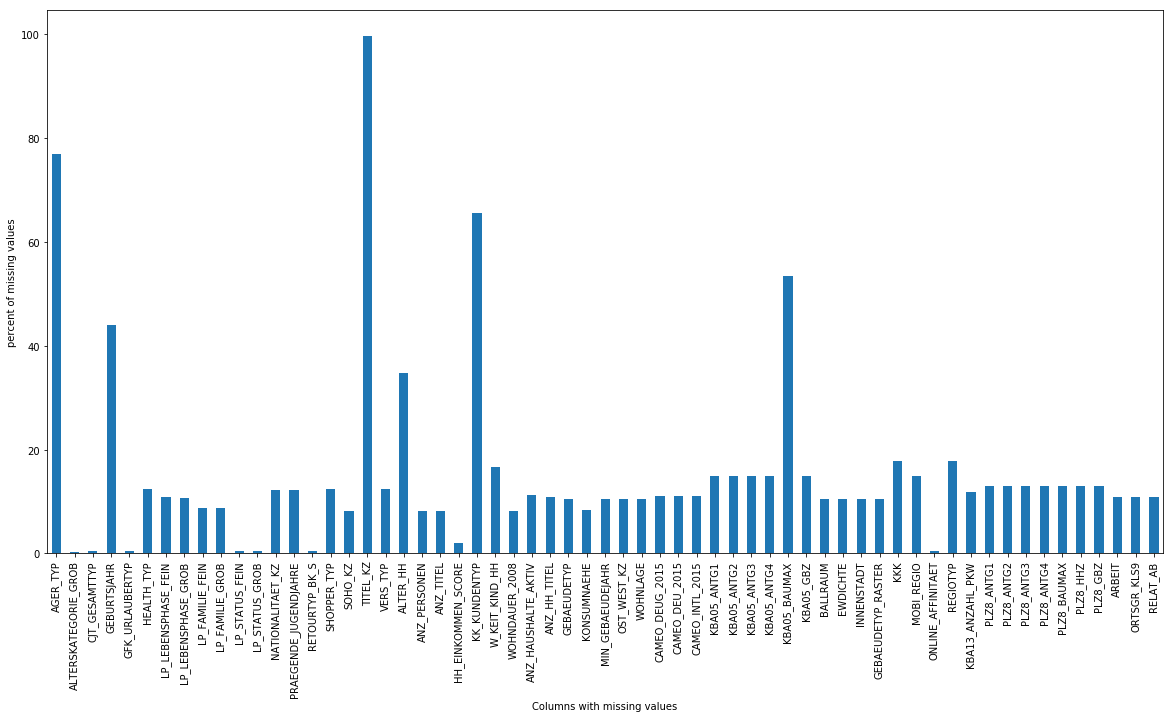

In [26]:
# Patterns in the amount of missing data in each column.

plot_missing_data.plot.bar(figsize=(20,10))
plt.xlabel('Columns with missing values')
plt.ylabel("percent of missing values")


In [27]:
sorted_plot_missing_data=plot_missing_data.sort_values(inplace= True)

Text(0,0.5,'percent of missing values')

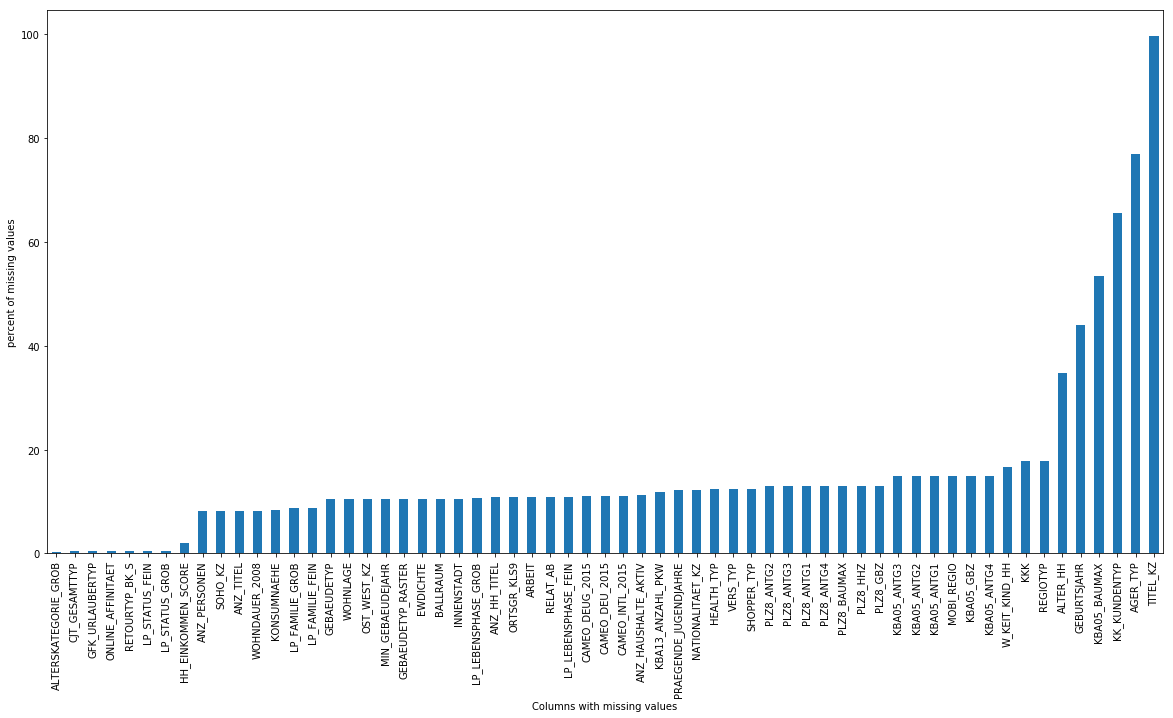

In [28]:
#Sorted 
plot_missing_data.plot.bar(figsize=(20,10))
plt.xlabel('Columns with missing values')
plt.ylabel("percent of missing values")


In [29]:
print('There are {} Columns with missing Data'.format(len(missing_data)))


There are 85 Columns with missing Data


In [30]:
## Now we will set 20% as limit to of missing Data
## So we will search for the Coloumns with more than 20% missing Data

columns_extract = [i for i in azdias.columns if (azdias[i].isnull().sum()/azdias.shape[0]) * 100 > 20]
print(columns_extract)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [31]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
for i in columns_extract:
    azdias.drop(i, axis=1, inplace=True)


In [32]:
azdias.shape[1]

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

It can be seen that only 7 columns have less percent of missing data and almost all of the columns have missing data ranging from 10% to 90%. Looking at the distribution of missing value counts and the bar plot above,  It is obvious from the distribution and the bar plot that the last few columns are outliers so I removed them from the data frame. and also after further analysis i removed many other columns. The removed columns are :'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [33]:
# How much data is missing in each row of the dataset?
azdias.isnull().any(axis=1)


0          True
1         False
2         False
3          True
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19        False
20         True
21        False
22        False
23         True
24         True
25         True
26         True
27        False
28        False
29         True
          ...  
891191    False
891192    False
891193    False
891194    False
891195    False
891196    False
891197    False
891198    False
891199    False
891200    False
891201    False
891202    False
891203     True
891204    False
891205    False
891206    False
891207    False
891208     True
891209    False
891210    False
891211    False
891212    False
891213    False
891214    False
891215    False
891216     True
891217     True
891218     True
891219    False
891220    False
Length: 891221, dtype: b

In [34]:
missing_row=azdias.isnull().sum(axis=1)

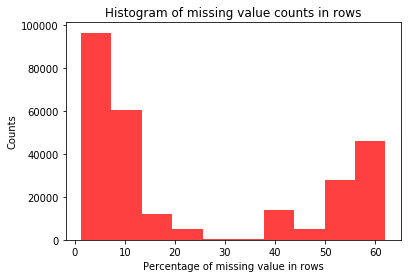

In [35]:
missing_row=missing_row[missing_row>0]/(len(azdias.columns))*100
missing_row.sort_values()

plt.hist(missing_row,color='Red', alpha=0.75)
plt.xlabel('Percentage of missing value in rows')
plt.ylabel('Counts')
plt.title('Histogram of missing value counts in rows')
plt.show()

In [36]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

less_10_missing = azdias[azdias.isnull().sum(axis=1) < 10].reset_index(drop=True)

greater_10_missing = azdias[azdias.isnull().sum(axis=1) >= 10].reset_index(drop=True)

In [37]:
print(len(less_10_missing))
print(len(greater_10_missing))

774743
116478


In [38]:
774743+116478

891221

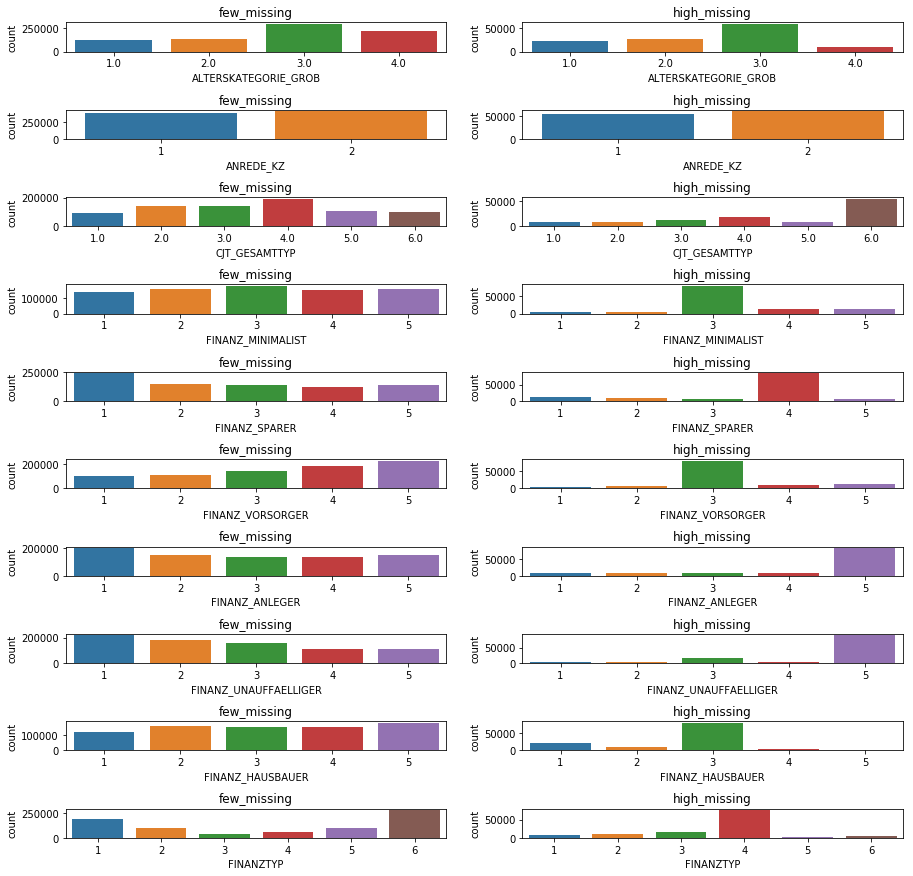

In [39]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

columns = less_10_missing.columns
def countplot(i,n):
    fig, axs = plt.subplots(n,2, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()
    for k in range(n):
        sns.countplot(less_10_missing[i[k]], ax=axs[k*2])
        axs[k*2].set_title('few_missing')
        sns.countplot(greater_10_missing[i[k]], ax=axs[k*2+1])
        axs[k*2+1].set_title('high_missing')
        
countplot(columns,10)

In [40]:
azdias_nan.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#filling missing values with mode 
for col in less_10_missing.columns:
    less_10_missing[col] = less_10_missing[col].fillna(less_10_missing[col].mode()[0])

#### Discussion 1.1.3: Assess Missing Data in Each Row

After analysing Histogram of missing value counts we can see that there is a lot of missing data . So, I set the limit of missing values in each row to 10 and I plot the countplot for 7 columns that are having no or very few missing values.

so i filled the missing values with the mode of each column. This way we won't lose much data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?
feat_info[1:2]
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [43]:
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#first we need to extract Categorical Variables
for i in less_10_missing.columns:
    if feat_info.loc[i].type == 'categorical':
        print(i, len(less_10_missing[i].unique()), less_10_missing[i].dtype)

ANREDE_KZ 2 int64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 int64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 int64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 object
CAMEO_DEU_2015 44 object


In [45]:
feat_info['col_names'] = feat_info.index

In [46]:
feat_info.index

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [47]:
#now we need to extract Columns with Binary Categories 
non_binary_categ = []
for i in less_10_missing.columns:
    if feat_info.loc[i].type == 'categorical' and len(less_10_missing[i].unique()) > 2:
        non_binary_categ.append(i)
#binary_categ_removed

In [48]:
non_binary_categ

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [49]:
#remove categorical columns with more than 2 categories
for i in non_binary_categ:
    less_10_missing.drop(i, axis=1, inplace=True)

In [50]:
less_10_missing.shape[1]

66

In [51]:
# Find the column names for mixed type columns
mixed_features = []
for i in less_10_missing.columns:
    if feat_info.loc[i].type == 'mixed':
        mixed_features.append(i)
        
mixed_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [52]:
# Re-encode categorical variable(s) to be kept in the analysis.
mixed_feature = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
for i in mixed_feature:
    less_10_missing.drop(i, axis=1, inplace=True)

In [53]:
less_10_missing.shape[1]

62

#### Discussion 1.2.1: Re-Encode Categorical Features

With respect to Categorical Features I removed non-binary categorical features. I also dropped mixed features as well  except the 2 features that we are asked to perform feature engineering on them and i have kept keep the binary categorical feature and will make dummy variable in further part as is. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
less_10_missing["PRAEGENDE_JUGENDJAHRE"]


0         14.0
1         15.0
2          8.0
3          8.0
4          3.0
5         10.0
6          8.0
7         11.0
8         15.0
9          3.0
10         8.0
11        15.0
12         5.0
13        14.0
14        10.0
15         9.0
16        10.0
17        14.0
18         9.0
19        14.0
20        11.0
21        10.0
22         6.0
23        10.0
24        15.0
25         8.0
26         4.0
27         8.0
28         8.0
29        10.0
          ... 
774713     4.0
774714     3.0
774715    14.0
774716     5.0
774717    11.0
774718     8.0
774719    14.0
774720    11.0
774721    15.0
774722    10.0
774723    14.0
774724    10.0
774725    10.0
774726    10.0
774727     3.0
774728    14.0
774729     2.0
774730     8.0
774731    14.0
774732     8.0
774733     8.0
774734     3.0
774735    11.0
774736    14.0
774737    10.0
774738    14.0
774739    10.0
774740    14.0
774741    14.0
774742     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 774743, dtype: float64

In [55]:
less_10_missing["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    203076
8.0     137903
10.0     83394
5.0      83112
3.0      52758
15.0     40803
11.0     34385
9.0      32939
6.0      25311
12.0     23925
4.0      20185
1.0      20106
2.0       7387
13.0      5520
7.0       3939
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [56]:
# we Divide this into two parts Year and Event
def year(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def event(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1


In [57]:
less_10_missing["Years"] = less_10_missing['PRAEGENDE_JUGENDJAHRE'].apply(year)


In [58]:
less_10_missing['Events'] = less_10_missing['PRAEGENDE_JUGENDJAHRE'].apply(event)

In [59]:
less_10_missing['Events']

0         1
1         0
2         1
3         1
4         1
5         1
6         1
7         0
8         0
9         1
10        1
11        0
12        1
13        1
14        1
15        0
16        1
17        1
18        0
19        1
20        0
21        1
22        0
23        1
24        0
25        1
26        0
27        1
28        1
29        1
         ..
774713    0
774714    1
774715    1
774716    1
774717    0
774718    1
774719    1
774720    0
774721    0
774722    1
774723    1
774724    1
774725    1
774726    1
774727    1
774728    1
774729    0
774730    1
774731    1
774732    1
774733    1
774734    1
774735    0
774736    1
774737    1
774738    1
774739    1
774740    1
774741    1
774742    1
Name: Events, Length: 774743, dtype: int64

In [60]:
#now we drop "PRAGENDE_JUGENDJAHRE" Column 
less_10_missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [61]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
less_10_missing["CAMEO_INTL_2015"]


0         51
1         24
2         12
3         43
4         54
5         22
6         14
7         13
8         15
9         51
10        43
11        33
12        41
13        41
14        24
15        34
16        55
17        51
18        43
19        33
20        51
21        13
22        12
23        51
24        14
25        41
26        25
27        41
28        24
29        25
          ..
774713    15
774714    44
774715    32
774716    43
774717    24
774718    55
774719    23
774720    24
774721    14
774722    51
774723    52
774724    41
774725    41
774726    24
774727    34
774728    25
774729    41
774730    14
774731    51
774732    41
774733    51
774734    51
774735    34
774736    23
774737    31
774738    41
774739    51
774740    24
774741    51
774742    43
Name: CAMEO_INTL_2015, Length: 774743, dtype: object

In [62]:
##for Cameo_intl_2015 into two variable Wealth and Life_stage

def wealth(x):
    if int(x) // 10 ==1:
           return 1
    if int(x) // 10 ==2:
           return 2
    if int(x) // 10 ==3:
           return 3
    if int(x) // 10 ==4:
           return 4
    if int(x) // 10 ==5:
           return 5
    
def life_stage (x):
    if int(x) % 10 ==1:
        return 1
    if int(x) % 10 ==2:
        return 2
    if int(x) % 10 ==3:
        return 3
    if int(x) % 10 ==4:
        return 4
    if int(x) % 10 ==5:
        return 5

In [63]:
less_10_missing['Wealth'] = less_10_missing['CAMEO_INTL_2015'].apply(wealth)
less_10_missing['life_stage'] = less_10_missing['CAMEO_INTL_2015'].apply(life_stage)
less_10_missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [64]:
less_10_missing["Wealth"]

0         5
1         2
2         1
3         4
4         5
5         2
6         1
7         1
8         1
9         5
10        4
11        3
12        4
13        4
14        2
15        3
16        5
17        5
18        4
19        3
20        5
21        1
22        1
23        5
24        1
25        4
26        2
27        4
28        2
29        2
         ..
774713    1
774714    4
774715    3
774716    4
774717    2
774718    5
774719    2
774720    2
774721    1
774722    5
774723    5
774724    4
774725    4
774726    2
774727    3
774728    2
774729    4
774730    1
774731    5
774732    4
774733    5
774734    5
774735    3
774736    2
774737    3
774738    4
774739    5
774740    2
774741    5
774742    4
Name: Wealth, Length: 774743, dtype: int64

In [65]:
less_10_missing['Wealth']

0         5
1         2
2         1
3         4
4         5
5         2
6         1
7         1
8         1
9         5
10        4
11        3
12        4
13        4
14        2
15        3
16        5
17        5
18        4
19        3
20        5
21        1
22        1
23        5
24        1
25        4
26        2
27        4
28        2
29        2
         ..
774713    1
774714    4
774715    3
774716    4
774717    2
774718    5
774719    2
774720    2
774721    1
774722    5
774723    5
774724    4
774725    4
774726    2
774727    3
774728    2
774729    4
774730    1
774731    5
774732    4
774733    5
774734    5
774735    3
774736    2
774737    3
774738    4
774739    5
774740    2
774741    5
774742    4
Name: Wealth, Length: 774743, dtype: int64

In [66]:
less_10_missing['Wealth'].value_counts()

5    223985
4    185971
2    183247
1    115911
3     65629
Name: Wealth, dtype: int64

In [67]:
less_10_missing['life_stage'].value_counts()

1    243693
4    226911
3    114588
5    114421
2     75130
Name: life_stage, dtype: int64

In [68]:
less_10_missing['OST_WEST_KZ'].value_counts()

W    610258
O    164485
Name: OST_WEST_KZ, dtype: int64

In [69]:
##Onehot encoding for the one binary variable that takes on non-numeric values
less_10_missing = pd.get_dummies(data=less_10_missing, columns=['OST_WEST_KZ'])

In [70]:
less_10_missing.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,6,1,5,1,0,1


In [71]:
names=list(less_10_missing.columns.values)

#### Discussion 1.2.2: Engineer Mixed-Type Features

AS given in Instruction two mixed type columns were broken down into 4 columns and the original columns were deleted from the data frame and i dropped the other mixed features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [72]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [73]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [74]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
    
    # remove selected columns 
    columns_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

    for i in columns_to_remove:
        df.drop(i, axis=1, inplace=True)
    
      #remove selected rows
    df = df[df.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
     #impute the remaining missing values 
    for i in df.columns:
        df[i] = df[i].fillna(df[i].mode()[0])
    
    non_binary_categ = []
    for i in df.columns:
        if feat_info.loc[i].type == 'categorical' and len(df [i].unique()) > 2:
            non_binary_categ.append(i)

    for i in non_binary_categ:
        df.drop(i, axis=1, inplace=True)

    df['Wealth'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(life_stage)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    df['Events'] = df['PRAEGENDE_JUGENDJAHRE'].apply(event)
    df['Years'] = df['PRAEGENDE_JUGENDJAHRE'].apply(year)
    
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    
    
    df = pd.get_dummies(data=df, columns=['OST_WEST_KZ'])
    
    # select, re-encode, and engineer column values.
    
    
    mixed_feature = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    for i in mixed_feature:
        df.drop(i, axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [89]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
import operator
from sklearn.preprocessing import LabelEncoder


In [90]:
# Apply feature scaling to the general population demographics data.
normalizer = StandardScaler()
less_10_missing[less_10_missing.columns] = normalizer.fit_transform(less_10_missing[less_10_missing.columns].as_matrix())


In [91]:
less_10_missing.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,0.563825,-0.179238,-0.132956,0.679358,1.106006,0.531136,1.170872,-1.249876,-0.519166,0.519166
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,0.563825,-0.179238,-0.132956,-0.795816,1.106006,-1.882757,-0.874330,0.763676,-0.519166,0.519166


### Discussion 2.1: Apply Feature Scaling

Before starting  dimensionality reduction to the data, we need to perform feature scaling so that the principal component are not influenced by the natural differences in scale for features.
for this we use sklearn.
For the scaling function, a StandardScaler is good  which scale each feature to mean 0 and standard deviation 1.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [92]:
# Apply PCA to the data.

Pca=PCA()
less_10_missing_pca=Pca.fit_transform(less_10_missing)

In [93]:
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

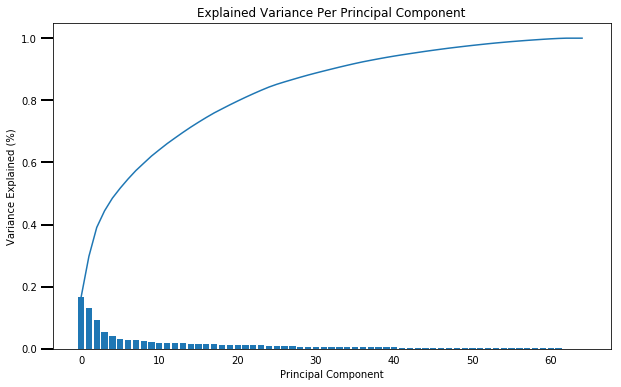

In [94]:
scree_plot(Pca)

In [95]:

# Re-apply PCA to the data while selecting for number of components to retain.
Pca = PCA(n_components=40)
less_10_missing_pca = Pca.fit_transform(less_10_missing)


In [96]:
less_10_missing_pca

array([[  3.87944164e+00,  -2.56332134e+00,  -2.92459345e+00, ...,
          7.47355306e-01,  -5.80045734e-01,  -5.02303426e-01],
       [ -9.84938764e-01,   2.37195215e-01,  -3.08660922e+00, ...,
          1.60515200e-01,  -4.09976563e-01,   3.67368923e-01],
       [ -3.88034203e+00,   1.32302693e+00,  -7.00262860e-01, ...,
         -6.50233261e-01,  -3.18661640e-01,  -5.77809381e-03],
       ..., 
       [ -8.91278102e-01,  -3.25236107e+00,  -2.89575992e+00, ...,
         -7.79173687e-01,  -4.69099883e-01,   3.83006505e-01],
       [  5.80443357e+00,  -3.27197015e+00,   2.34079203e+00, ...,
         -6.04552969e-02,  -6.46607924e-01,   3.04123742e-01],
       [ -8.34131774e-01,   9.85861930e-01,   3.07546482e+00, ...,
         -7.00184463e-02,  -2.82708074e-01,  -2.06253884e-01]])

### Discussion 2.2: Perform Dimensionality Reduction

 we can see after 40 features the variance explained decreases and the cumulative explained variance becomes 1. So I choose 40 features to do the PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [97]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights(pca, i):
    weight = {}
    for counter, feature in enumerate(less_10_missing.columns):
        weight[feature] = pca.components_[i][counter]
    
    sorted_weights = sorted(weight.items(), key=operator.itemgetter(1), reverse=True)
    
    return sorted_weights



In [98]:
weights(Pca,1)

[('ALTERSKATEGORIE_GROB', 0.25825352108457489),
 ('SEMIO_ERL', 0.23064059111475893),
 ('FINANZ_VORSORGER', 0.22994770690546965),
 ('SEMIO_LUST', 0.180619760071458),
 ('RETOURTYP_BK_S', 0.16343897132867688),
 ('SEMIO_KRIT', 0.11812735128057306),
 ('FINANZ_HAUSBAUER', 0.11809520431610308),
 ('SEMIO_KAEM', 0.11420261565889994),
 ('W_KEIT_KIND_HH', 0.11359703209660378),
 ('PLZ8_ANTG3', 0.096517466234200031),
 ('EWDICHTE', 0.093505764793304622),
 ('ORTSGR_KLS9', 0.092663162823397469),
 ('ANREDE_KZ', 0.091920570991854939),
 ('PLZ8_ANTG4', 0.091668299854104213),
 ('Wealth', 0.075789914586243484),
 ('KBA05_ANTG4', 0.072318448205752048),
 ('SEMIO_DOM', 0.071579702143578672),
 ('ARBEIT', 0.069990555415379893),
 ('RELAT_AB', 0.066081785722873904),
 ('PLZ8_ANTG2', 0.06564581462676887),
 ('FINANZ_MINIMALIST', 0.064211049327796629),
 ('ANZ_HAUSHALTE_AKTIV', 0.063533117002543618),
 ('WOHNDAUER_2008', 0.058089820587480898),
 ('HH_EINKOMMEN_SCORE', 0.056512097268500899),
 ('KBA05_ANTG3', 0.047259789989

In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(Pca,2)

[('SEMIO_VERT', 0.34625904854660455),
 ('SEMIO_SOZ', 0.26296011041488004),
 ('SEMIO_FAM', 0.24923008052031442),
 ('SEMIO_KULT', 0.23311362182684034),
 ('FINANZ_MINIMALIST', 0.15589995885584707),
 ('RETOURTYP_BK_S', 0.10929750720289193),
 ('FINANZ_VORSORGER', 0.099997132473597747),
 ('W_KEIT_KIND_HH', 0.084925489077947725),
 ('ALTERSKATEGORIE_GROB', 0.079447610731880544),
 ('SEMIO_REL', 0.068885441330329644),
 ('SEMIO_LUST', 0.06420955003953055),
 ('SEMIO_MAT', 0.054992010215762471),
 ('ORTSGR_KLS9', 0.048529473001822712),
 ('GREEN_AVANTGARDE', 0.048010214568346254),
 ('PLZ8_ANTG4', 0.047551633847186421),
 ('PLZ8_ANTG3', 0.047513155722019654),
 ('EWDICHTE', 0.047396188843603422),
 ('ARBEIT', 0.037133999104750827),
 ('RELAT_AB', 0.032646459200687282),
 ('WOHNDAUER_2008', 0.03247512090731372),
 ('PLZ8_ANTG2', 0.030947224178978196),
 ('KBA05_ANTG4', 0.028922475752229209),
 ('Wealth', 0.028514409630289759),
 ('ANZ_HAUSHALTE_AKTIV', 0.025828184670738406),
 ('OST_WEST_KZ_O', 0.019721878874285

In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights(Pca,3)

[('GREEN_AVANTGARDE', 0.3751370952062944),
 ('EWDICHTE', 0.2644517074548563),
 ('ORTSGR_KLS9', 0.23970819380826644),
 ('OST_WEST_KZ_W', 0.20391390574169405),
 ('PLZ8_HHZ', 0.1654080815433196),
 ('PLZ8_ANTG2', 0.13129185965272197),
 ('ONLINE_AFFINITAET', 0.11541262799844906),
 ('SEMIO_DOM', 0.10981397426379733),
 ('PLZ8_ANTG3', 0.099517460323178306),
 ('FINANZ_UNAUFFAELLIGER', 0.098431884718137422),
 ('RELAT_AB', 0.094000521812710833),
 ('KBA05_ANTG1', 0.088648104684604115),
 ('ANZ_PERSONEN', 0.084821307280917191),
 ('KBA13_ANZAHL_PKW', 0.082121787688941184),
 ('SEMIO_KAEM', 0.073400413219912627),
 ('PLZ8_ANTG4', 0.072396802528849891),
 ('PLZ8_GBZ', 0.065197546337229642),
 ('SEMIO_TRADV', 0.056589694106406477),
 ('MOBI_REGIO', 0.052170441310300977),
 ('SEMIO_RAT', 0.05078024873628794),
 ('FINANZ_MINIMALIST', 0.050080255979937482),
 ('ANZ_TITEL', 0.044906987425301331),
 ('life_stage', 0.042429674926237761),
 ('KBA05_GBZ', 0.039726177681855025),
 ('ANZ_HH_TITEL', 0.034983489886197726),
 (

### Discussion 2.3: Interpret Principal Components

We can see some relationships between negative and positive weights . For example, in the 1st principle component 'ALTERSKATEGORIE_GROB' with positive weight as opposed Years with negative weight. if ''ALTERSKATEGORIE_GROB' goes down which means getting younger , the 'YEARS' goes down which means getting younger.

For 2nd Principal Component Analysis,'SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_KULT', 'SEMIO_SOZ', 'SEMIO_MAT' these have Positive Values and each Belong to same Group as given in Dictonary so all will either increase or decrease with each other.

For 3rd Principal Component Analysis,'OST_WEST_KZ_O' has a negative value while 'OST_WEST_KZ_W' ha s a positive value, they both show building Locations 'OST_WEST_KZ_O' for East and West Germany.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [101]:
# Over a number of different cluster counts...
##for this we will make a function 
def Kmeans_Fun(x,centroid):
    kmeans=KMeans(n_clusters=centroid)
    kmeans_model=kmeans.fit(x)
    score=kmeans_model.score(x)
    return score
    

In [ ]:
score=[]
centroid=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
for i in centroid:
    score.append(Kmeans_Fun(less_10_missing_pca, i))


In [ ]:

plt.plot(centroid, np.abs(score), linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('score');
plt.title(' vs. K');

In [103]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [104]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=11)
new_kmeans_model = kmeans.fit(less_10_missing_pca)

In [105]:
predictions_genral_pop_demo = new_kmeans_model.predict(less_10_missing_pca)

In [106]:
predictions_genral_pop_demo

array([ 5,  6, 10, ...,  9,  4,  8], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

Looking at the plot above, we can see that the score keeps decreasing and there is  an elbow at 14. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [107]:
# Load in the customer demographics data.
customers =  pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [108]:
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [109]:
clean_customers = clean_data(customers)

In [110]:
clean_customers.shape

(136159, 65)

In [111]:
clean_customers.isnull().any().sum()

0

In [112]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers[clean_customers.columns] = normalizer.transform(clean_customers[clean_customers.columns].as_matrix())

#transform the customers data using pca object
Pca_clean_customers = Pca.transform(clean_customers)
#predict clustering using the kmeans object
predict_customers =  new_kmeans_model.predict(Pca_clean_customers)

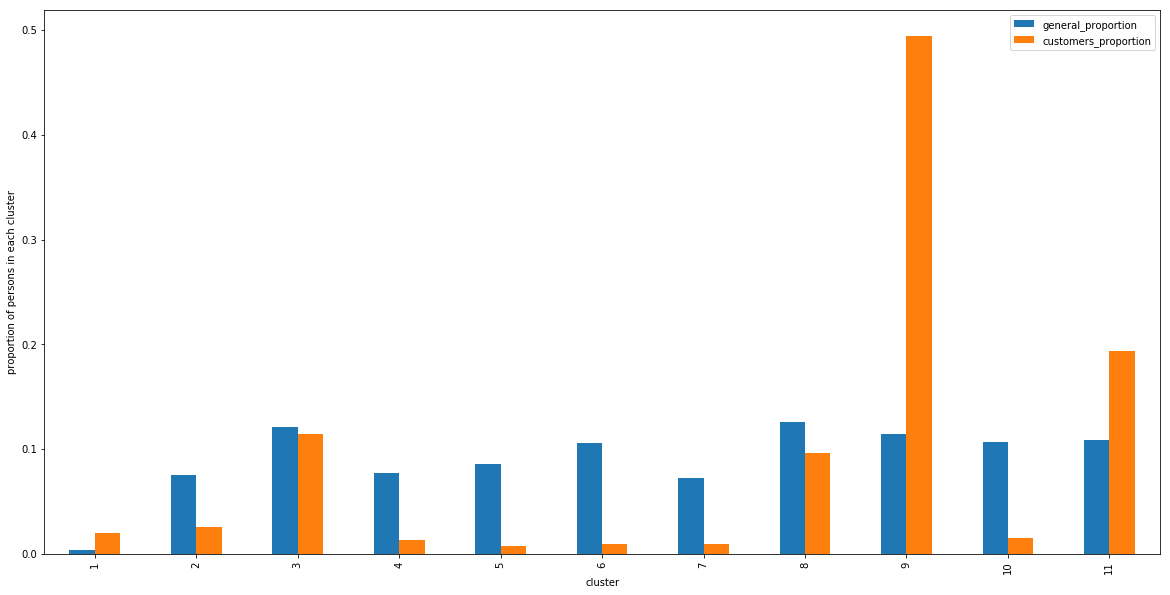

In [126]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_proportion = []
customers_proportion = []
x = [k+1 for k in range(11)]
for i in range(11):
    general_proportion.append((predictions_genral_pop_demo == i).sum()/len(predictions_genral_pop_demo))
    customers_proportion.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_proportion, 'customers_proportion':customers_proportion})

df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(20,10))
plt.ylabel('proportion of persons in each cluster')
plt.show()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [122]:
##We can see clearly see in cluster number 9 customer data is over-represented
over1 = normalizer.inverse_transform(Pca.inverse_transform(Pca_clean_customers[np.where(predict_customers==8)]))
over_customers = pd.DataFrame(data=over1,
          index=np.array(range(0, over1.shape[0])),
          columns=less_10_missing.columns)
over_customers.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
0,4.216380,0.876624,5.262349,0.903824,5.394498,1.119724,1.277535,2.224971,-0.479154,0.979197,...,5.121949,1.238185,2.100683,0.716192,2.558088,1.479154,-0.132079,2.031261,-0.036636,1.036636
1,3.525464,0.985684,4.992517,0.767647,5.022850,1.523430,0.915206,2.122592,-1.484819,1.897097,...,3.856599,1.116124,1.442263,1.003064,2.752068,2.484819,0.934824,0.972164,0.004446,0.995554
2,3.114929,0.972063,4.809913,0.948809,4.789474,0.214602,2.163681,2.691846,-0.958031,2.967025,...,4.734935,3.367075,5.785258,4.726219,3.069769,1.958031,-0.411307,1.959039,0.007555,0.992445
3,3.189665,1.093055,5.453251,0.409622,5.404297,0.929769,1.708948,2.316361,-0.505680,1.835700,...,5.238868,1.970272,2.015269,2.143574,2.580369,1.505680,0.177674,2.043847,0.046969,0.953031
4,4.100288,0.837586,5.313465,0.859775,5.125893,0.535822,1.512738,2.161861,-1.452949,1.010222,...,3.194797,2.581149,3.867351,3.291146,2.647694,2.452949,-0.452280,2.000367,0.037549,0.962451
5,2.878719,0.960848,5.227914,1.094991,4.390677,0.411346,2.551879,1.047249,-1.463980,3.008662,...,5.147699,3.327945,6.044761,3.652665,3.683801,2.463980,-0.600337,3.887618,-0.025902,1.025902
6,3.369507,0.945172,5.225115,0.807610,4.833675,0.397852,1.866511,2.294425,-0.942318,0.916181,...,3.734262,1.518841,3.160809,1.502036,2.937000,1.942318,-0.268700,2.053484,0.025855,0.974145
7,3.550721,1.057480,4.894837,1.710306,4.575087,2.912533,1.595634,1.203581,-0.523896,2.053652,...,4.879231,1.276643,0.966211,0.717611,3.555570,1.523896,1.448301,4.106156,-0.027017,1.027017
8,3.224533,1.008013,4.933915,1.908941,3.639274,1.473014,3.589593,1.013076,-0.988254,2.961625,...,4.348488,3.998963,5.077559,4.969571,4.624602,1.988254,0.666109,3.969115,-0.010293,1.010293
9,3.154834,1.062019,5.520080,0.518493,5.171081,0.062494,1.255641,2.163820,-1.456428,0.977036,...,5.699011,2.295516,4.811708,1.659526,2.560239,2.456428,-0.249064,3.060263,0.113864,0.886136


In [123]:
over2 = normalizer.inverse_transform(Pca.inverse_transform(less_10_missing_pca[np.where(predictions_genral_pop_demo==8)]))
over_genral = pd.DataFrame(data=over2,
          index=np.array(range(0, over2.shape[0])),
          columns=less_10_missing.columns)
over_genral.sample(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
72078,3.115646,1.068242,3.537206,1.290386,5.512362,1.285545,1.550628,4.246625,0.004280,3.015886,...,3.779520,2.612848,5.555492,2.295079,2.967232,0.995720,1.685231,1.896967,-0.021097,1.021097
74122,3.232434,1.069202,4.305942,2.673928,3.698733,3.318382,1.421915,1.159969,-0.012112,2.893754,...,4.090459,2.421894,4.266318,2.613270,4.621559,1.012112,2.097897,3.046628,-0.010896,1.010896
87411,4.357495,1.148288,5.374051,0.502833,4.767975,1.172525,1.641625,1.364156,0.007994,2.066208,...,3.699777,1.415519,1.943286,0.760564,2.870121,0.992006,1.922127,4.933060,-0.051503,1.051503
45884,2.875478,1.092624,5.175362,1.258735,4.862229,2.357246,0.917062,1.566267,0.046704,3.041418,...,4.552490,1.626110,2.788920,1.458339,3.294551,0.953296,0.587046,2.870717,0.058980,0.941020
36597,2.775921,1.050400,4.935844,1.978628,3.812313,2.331332,2.263523,0.937463,-0.019521,2.973539,...,4.888603,2.488281,1.895806,2.550900,4.122640,1.019521,2.261264,3.976735,0.039530,0.960470
30830,4.024113,1.102173,5.633058,0.797626,4.928519,1.345696,1.273633,1.318814,-0.005295,1.890342,...,3.895456,3.265185,3.246659,3.817823,2.938235,1.005295,1.741602,3.935673,-0.032633,1.032633
63614,3.173848,0.983852,4.890852,1.599033,4.255583,2.277489,1.452614,1.692706,-0.016077,3.011570,...,4.042125,2.532795,2.311773,2.472732,3.466651,1.016077,1.924547,2.876248,0.032696,0.967304
11857,3.074882,1.121807,3.501790,2.659960,3.846427,2.758991,2.351437,2.611970,-0.024639,2.927194,...,3.189648,2.611993,4.239220,2.589239,4.360151,1.024639,3.444285,1.078528,0.034512,0.965488
25717,2.790555,1.155370,4.374017,1.092759,5.058932,0.855314,1.906062,3.419332,0.009837,3.154162,...,3.227446,1.975957,4.162634,1.887338,2.628032,0.990163,1.793470,3.915284,-0.002969,1.002969
81520,4.107717,1.267757,3.232751,2.521503,3.134768,4.344627,1.395977,3.617672,-0.005063,2.056781,...,2.361871,3.542463,1.247707,2.543982,4.114605,1.005063,3.428599,3.070719,1.086164,-0.086164


After analysing above two results for over-represtation which is can be seen in cluster 9  ,it seems that this cluster belongs to poeple in middle age group and can be said to be investors and saves money.

In [124]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under1 = normalizer.inverse_transform(Pca.inverse_transform(Pca_clean_customers[np.where(predict_customers==5)]))
ud_customer = pd.DataFrame(data=under1,
          index=np.array(range(0, under1.shape[0])),
          columns=less_10_missing.columns)
ud_customer.sample(10)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
515,1.173788,2.036899,2.636325,1.581246,4.936080,1.632917,1.846251,4.654949,-2.009315,1.040291,...,3.058173,4.060781,7.032169,4.948855,3.470363,3.009315,1.647054,2.223785,-0.000427,1.000427
237,2.586914,2.201977,0.267166,4.525506,2.794722,4.008980,4.341026,5.302884,-1.490402,2.038783,...,3.292200,3.403969,7.140550,4.736207,5.548306,2.490402,0.350369,2.139729,-0.041991,1.041991
812,1.169315,2.056540,0.862482,4.308980,1.896126,4.732628,3.065533,5.070108,-1.497950,2.927853,...,1.064906,3.878815,7.866808,3.279448,5.531235,2.497950,1.494262,6.191817,1.042317,-0.042317
671,1.118651,1.917099,2.145605,3.106298,2.999466,3.794371,1.692738,4.404732,-0.042472,3.009542,...,1.366833,3.797308,8.785554,3.338028,4.522903,1.042472,1.763717,4.115106,1.043483,-0.043483
459,0.908477,1.915394,2.665933,2.258623,4.025172,2.107100,2.922815,3.551840,-1.491554,3.032940,...,2.744751,4.058018,6.556546,5.011845,4.237101,2.491554,0.966738,5.027285,0.001618,0.998382
742,1.195323,1.850485,2.632868,1.560471,3.854722,1.530103,1.139817,4.744903,-2.014814,1.085290,...,1.185267,3.883639,8.792903,3.075475,3.290944,3.014814,1.449542,2.073804,1.000646,-0.000646
296,0.960466,1.722019,2.435220,1.692847,4.229349,3.074095,1.191385,5.347655,-1.997210,2.901232,...,1.674061,2.828069,2.342470,2.228727,3.335062,2.997210,1.207215,1.146435,1.009826,-0.009826
816,1.287485,1.986881,2.401889,2.243374,3.526650,2.282398,1.144628,4.431481,-1.471166,2.859029,...,1.618310,3.713816,8.077938,3.499966,4.235605,2.471166,0.859241,4.919630,1.091811,-0.091811
1272,1.805266,1.924698,1.987138,2.508431,3.004487,2.779881,1.180410,4.873514,-1.480845,2.053033,...,2.641501,4.057636,8.259366,3.107248,4.436214,2.480845,0.976280,4.955619,1.045160,-0.045160
690,2.153839,2.076173,2.093533,1.926274,4.825942,2.501575,1.927262,4.892508,-2.007074,2.267772,...,4.123726,2.302551,5.073190,2.595941,3.627745,3.007074,1.361877,1.171872,-0.029775,1.029775


In [125]:
under2 = normalizer.inverse_transform(Pca.inverse_transform(less_10_missing_pca[np.where(predictions_genral_pop_demo==5)]))
under_genral = pd.DataFrame(data=under2,
          index=np.array(range(0, under2.shape[0])),
          columns=less_10_missing.columns)
under_genral.sample(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Years,Events,Wealth,life_stage,OST_WEST_KZ_O,OST_WEST_KZ_W
80032,2.143260,1.979798,2.554623,2.976876,3.340113,2.937599,1.976576,2.578180,-0.000289,1.911164,...,2.925317,2.246426,5.734629,2.772982,4.817504,1.000289,4.845710,3.970312,-0.060174,1.060174
2854,1.548296,1.983940,0.789541,4.614815,1.527272,5.432713,2.552228,4.722508,0.011362,2.065354,...,2.718148,4.185090,4.759562,3.829738,5.623336,0.988638,4.739055,4.916295,0.960617,0.039383
13595,1.367948,2.065099,1.773019,4.301524,1.162278,3.289791,5.153791,2.915224,0.020547,2.103075,...,2.835866,4.050520,8.128534,4.827767,5.974258,0.979453,4.517639,0.904285,0.007458,0.992542
49442,1.247867,2.101874,1.984085,4.491001,1.806364,4.660264,4.353451,2.698864,0.008295,0.996305,...,3.187659,4.714206,6.557003,5.357399,6.155285,0.991705,4.404348,1.172339,0.104034,0.895966
23455,1.625865,2.091797,1.098574,4.288217,2.019094,4.150352,4.125911,4.034310,-0.004421,2.099303,...,3.263499,3.771701,6.434403,5.009953,5.656671,1.004421,5.136185,1.069491,-0.005980,1.005980
82294,2.473405,1.707107,0.523244,5.141000,2.399805,4.512788,4.480028,4.945618,0.015145,3.006571,...,2.181413,3.433883,8.249923,3.512271,5.969667,0.984855,4.774059,0.967065,-0.060262,1.060262
55392,2.229948,1.835841,0.533269,5.039555,2.753120,4.355828,4.169010,5.124973,0.979359,2.963088,...,2.093991,3.081832,7.385715,2.859961,6.161057,0.020641,5.314297,1.105032,-0.048424,1.048424
52760,2.679036,2.036494,1.518865,4.461548,1.979611,4.474996,3.431977,2.635017,0.024863,2.968864,...,1.930852,4.112258,7.626882,4.925295,5.837211,0.975137,3.832797,4.972818,0.059681,0.940319
29676,2.879408,1.877755,0.413789,5.192601,2.456251,4.732895,4.251522,4.858692,-0.005813,3.084642,...,3.085724,3.827643,8.612011,4.138855,5.953688,1.005813,3.850252,0.979765,-0.120994,1.120994
10959,1.396298,2.112848,1.011897,4.545826,1.762371,3.879117,4.376351,4.099022,-0.009792,2.068176,...,1.891548,3.343667,9.046635,3.775238,5.833325,1.009792,4.238332,0.950923,0.075715,0.924285


After analysing above two results for under-represtation which is in cluster 6 ,it seems that this also cluster belongs to poeple are young in age group who are not potential investors.

### Discussion 3.3: Compare Customer Data to Demographics Data

By examing the bar plot, we can see that for mostly all of clusters there is a good match between the general population and the customers population. So, the company can use this info to select a part of the general population for their business. We must also look at how how much Data we removed and how much we filled with mode. I will safe if company can get most of data with less or most important features than it will be very best match.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.